In [242]:
import pandas as pd
import numpy as np
import random
import math
import time

import matplotlib.pyplot as plt
from functions import train_test

In [243]:
def GBPRplus(rating_matrix, group_size=3, item_size = 3, latent_features=25, rho=0.5, reg_terms= (0.001, 0.001, 0.001), learning_rate=0.01, iterations=100):
    U = np.random.rand(rating_matrix.shape[0], latent_features)
    V = np.random.rand(rating_matrix.shape[1], latent_features)
    b = np.random.rand(rating_matrix.shape[1])
    
    au, av, bv = reg_terms
    
    items_liked = []
    items_not_liked = []
    
    for row in rating_matrix:
        liked_list = []
        not_liked = []
        
        for index, val in enumerate(row):
            if val == 1:
                liked_list.append(index)
            else:
                not_liked.append(index)
                
        items_liked.append(liked_list)
        items_not_liked.append(not_liked)
    
    user_liked = []
    for col in rating_matrix.T:
        user_list = []
        
        for index, val in enumerate(col):
            if val == 1:
                user_list.append(index)
            
        user_liked.append(user_list)
                
    for t1 in range(iterations*rating_matrix.shape[0]):
        #for t2 in range(rating_matrix.shape[0]):
        
        user = random.randint(0,rating_matrix.shape[0] - 1)
        
        if len(items_liked[user]) >= 1: 
            item = np.random.choice(items_liked[user], 1)[0]
            item_liked = True
        else:
            item_liked = False
        
        if len(user_liked[item]) >= group_size and len(items_not_liked[user]) >= item_size and item_liked:
            
            group = np.setdiff1d(user_liked[item], user)
            group = np.random.choice(group, group_size-1, replace=False)

            item_set = np.random.choice(items_not_liked[user], item_size, replace=False)
            
            U_group = U[user].copy()
            for w in group:
                U_group += U[w]
            U_group /= group_size
            
            user_pref_i = np.dot(U[user], V[item]) + b[item]
            group_pref_i = np.dot(U_group, V[item]) + b[item]
      
            fused_pref_i = rho*group_pref_i + (1-rho)*user_pref_i
            
            deriv_list = []
            for j in item_set:
                user_pref_j = np.dot(U[user], V[j]) + b[j]
                pairwise_pref = fused_pref_i - user_pref_j
                expon = math.exp(-1*pairwise_pref)
                
                deriv_list.append((-1/item_size)*expon/(1+expon))
                
            deriv_list = np.array(deriv_list)
            deriv_sum = sum(deriv_list)
            
            grad_Uu = au*U[user]
            for j, driv in zip(item_set, deriv_list):
                grad_Uu += driv*((1-rho)*V[item] + rho*V[item]/group_size - V[j])
            
            grad_Uw = []
            for w in group:
                grad = V[item]*deriv_sum*rho/group_size + au*U[w]/group_size
                grad_Uw.append(grad)
            
            grad_Vi = deriv_sum*((1-rho)*U[user] + rho*U_group) + av*V[item]
            grad_bi = deriv_sum + bv*b[item]
            
            grad_Vj = []
            grad_bj = []
            for j, driv in zip(item_set, deriv_list):
                grad_V = -1*driv*U[user] + av*V[j]
                grad_Vj.append(grad_V)
                
                grad_b = -1*driv + bv*b[j]
                grad_bj.append(grad_b)
           
            U[user] -= learning_rate*grad_Uu
            
            for w, grad in zip(group, grad_Uw):
                U[w] -= learning_rate*grad
            
            V[item] -= learning_rate*grad_Vi
            b[item] -= learning_rate*grad_bi
            
            for j, grad_V, grad_b in zip(item_set, grad_Vj, grad_bj):
                V[j] -= learning_rate*grad_V
                b[j] -= learning_rate*grad_b
        
    return U, V, b

In [244]:
def get_recommendations(pred, k=5):
    rec_list = []
    
    for u in range(pred.shape[0]):
        rec = np.argpartition(pred[u],-k)[-k:]
        rec_list.append(rec)
    
    return np.array(rec_list)

In [245]:
def get_metrics(test_matrix, user_rec):
    true_positive = 0
    false_positive = 0
    false_negative = 0
    
    for u in range(user_rec.shape[0]):
        for i in user_rec[u]:
            if test_matrix[u][i] == 1:
                true_positive+=1
            else:
                false_positive+=1
                
    for u in range(test_matrix.shape[0]):
        for i in range(test_matrix.shape[1]):
            if test_matrix[u][i] == 1 and i not in user_rec[u]:
                false_negative+=1
    
    precision = true_positive/(true_positive + false_positive)
    recall = true_positive/(true_positive + false_negative)
    F1_score = 2*(precision*recall)/(precision + recall)

    print("Precision :", precision)
    print("Recall :", recall)
    print("F1 Score :", F1_score)
    
    return precision, recall, F1_score

In [246]:
rating_df = pd.read_csv('data/user_rating_pt.csv')
rating_df.columns = rating_df.columns.astype(int)

In [247]:
rating_treshold = 3.5

rating_df[rating_df < rating_treshold] = 0
rating_df[rating_df >= rating_treshold] = 1
rating_df.columns = range(len(rating_df.columns))

rating_df.head()

,0,1,2,3,4,5,6,7,8,9,...,9714,9715,9716,9717,9718,9719,9720,9721,9722,9723
0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0,0.0,0.0,...,0.0,0,0,0,0.0,0,0.0,0.0,0.0,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,...,0.0,0,0,0,0.0,0,0.0,0.0,0.0,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,...,0.0,0,0,0,0.0,0,0.0,0.0,0.0,0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,...,0.0,0,0,0,0.0,0,0.0,0.0,0.0,0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,...,0.0,0,0,0,0.0,0,0.0,0.0,0.0,0


In [248]:
rating_matrix = np.array(rating_df)

In [249]:
known = []

for u in range(rating_matrix.shape[0]):
    for i in range(rating_matrix.shape[1]):
        if rating_matrix[u,i] > 0:
            known.append((u, i))

training, testing = train_test(known, test_size=0.3)

In [250]:
train_matrix = np.zeros((rating_matrix.shape[0], rating_matrix.shape[1]))
test_matrix = np.zeros((rating_matrix.shape[0], rating_matrix.shape[1]))

for u, i in training:
    train_matrix[u][i] = 1

for u, i in testing:
    test_matrix[u][i] = 1

In [251]:
scores = []

In [252]:
U, V, b = GBPRplus(train_matrix, rho=1, iterations=75, latent_features=2)
pred = np.dot(U, V.T) + b

train_replace = pred.min() - 1

for u, i in training:
    pred[u][i] = train_replace
    
user_rec = get_recommendations(pred, k=10)

scores.append(get_metrics(test_matrix, user_rec))

Precision : 0.13934426229508196
Recall : 0.04590872265730489
F1 Score : 0.06906357911842373


In [253]:
U, V, b = GBPRplus(train_matrix, rho=1, iterations=75, latent_features=3)
pred = np.dot(U, V.T) + b

train_replace = pred.min() - 1

for u, i in training:
    pred[u][i] = train_replace
    
user_rec = get_recommendations(pred, k=10)

scores.append(get_metrics(test_matrix, user_rec))

Precision : 0.12819672131147541
Recall : 0.0422360248447205
F1 Score : 0.06353849278894982


In [254]:
U, V, b = GBPRplus(train_matrix, rho=1, iterations=75, latent_features=5)
pred = np.dot(U, V.T) + b

train_replace = pred.min() - 1

for u, i in training:
    pred[u][i] = train_replace
    
user_rec = get_recommendations(pred, k=10)

scores.append(get_metrics(test_matrix, user_rec))

Precision : 0.13098360655737704
Recall : 0.0431541992978666
F1 Score : 0.06491976437131831


In [255]:
U, V, b = GBPRplus(train_matrix, rho=1, iterations=75, latent_features=7)
pred = np.dot(U, V.T) + b

train_replace = pred.min() - 1

for u, i in training:
    pred[u][i] = train_replace
    
user_rec = get_recommendations(pred, k=10)

scores.append(get_metrics(test_matrix, user_rec))

Precision : 0.13131147540983606
Recall : 0.04326221982176614
F1 Score : 0.06508226691042047


In [256]:
U, V, b = GBPRplus(train_matrix, rho=1, iterations=75, latent_features=10)
pred = np.dot(U, V.T) + b

train_replace = pred.min() - 1

for u, i in training:
    pred[u][i] = train_replace
    
user_rec = get_recommendations(pred, k=10)

scores.append(get_metrics(test_matrix, user_rec))

Precision : 0.13245901639344262
Recall : 0.043640291655414526
F1 Score : 0.06565102579727808


In [257]:
U, V, b = GBPRplus(train_matrix, rho=1, iterations=75, latent_features=15)
pred = np.dot(U, V.T) + b

train_replace = pred.min() - 1

for u, i in training:
    pred[u][i] = train_replace
    
user_rec = get_recommendations(pred, k=10)

scores.append(get_metrics(test_matrix, user_rec))

Precision : 0.13081967213114754
Recall : 0.04310018903591682
F1 Score : 0.0648385131017672


In [258]:
U, V, b = GBPRplus(train_matrix, rho=1, iterations=75, latent_features=20)
pred = np.dot(U, V.T) + b

train_replace = pred.min() - 1

for u, i in training:
    pred[u][i] = train_replace
    
user_rec = get_recommendations(pred, k=10)

scores.append(get_metrics(test_matrix, user_rec))

Precision : 0.11426229508196721
Recall : 0.03764515257899001
F1 Score : 0.056632134877107464


In [259]:
U, V, b = GBPRplus(train_matrix, rho=1, iterations=75, latent_features=25)
pred = np.dot(U, V.T) + b

train_replace = pred.min() - 1

for u, i in training:
    pred[u][i] = train_replace
    
user_rec = get_recommendations(pred, k=10)

scores.append(get_metrics(test_matrix, user_rec))

Precision : 0.12245901639344263
Recall : 0.04034566567647853
F1 Score : 0.06069469835466179


## Graphs

In [260]:
latent_features = [2,3,5,7,10,15,20, 25]

precision_list = []
recall_list = []
F1_list = []

for s in scores:
    precision_list.append(s[0])
    recall_list.append(s[1])
    F1_list.append(s[2])

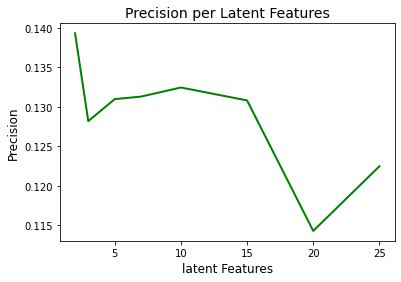

In [261]:
plt.plot(latent_features, precision_list, color='green', linewidth=2)

plt.title('Precision per Latent Features', size=14)
plt.xlabel('latent Features', size=12)
plt.ylabel('Precision', size=12)


plt.show()

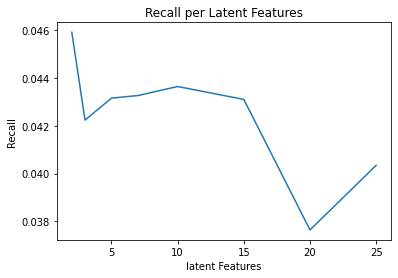

In [262]:
plt.plot(latent_features, recall_list)

plt.title('Recall per Latent Features')
plt.xlabel('latent Features')
plt.ylabel('Recall')


plt.show()

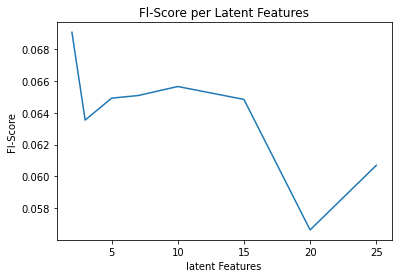

In [263]:
plt.plot(latent_features, F1_list)

plt.title('Fl-Score per Latent Features')
plt.xlabel('latent Features')
plt.ylabel('Fl-Score')


plt.show()

## Set Size

In [264]:
sizes = [2,3,4,6,8,10,12,14,16]
scores_set_size = []

In [265]:
for size in sizes:
    U, V, b = GBPRplus(train_matrix, rho=1, group_size=size, item_size=size, iterations=75, latent_features=2)
    pred = np.dot(U, V.T) + b

    train_replace = pred.min() - 1

    for u, i in training:
        pred[u][i] = train_replace

    user_rec = get_recommendations(pred, k=10)
    
    print("set size =",size)
    scores_set_size.append(get_metrics(test_matrix, user_rec))
    print()

set size = 2
Precision : 0.14065573770491804
Recall : 0.04634080475290305
F1 Score : 0.06971358927483243

set size = 3
Precision : 0.1318032786885246
Recall : 0.04342425060761545
F1 Score : 0.06532602071907374

set size = 4
Precision : 0.14540983606557378
Recall : 0.047907102349446395
F1 Score : 0.07206987609181394

set size = 6
Precision : 0.13278688524590163
Recall : 0.04374831217931407
F1 Score : 0.06581352833638025

set size = 8
Precision : 0.1437704918032787
Recall : 0.04736699972994869
F1 Score : 0.07125736339630306

set size = 10
Precision : 0.13278688524590163
Recall : 0.04374831217931407
F1 Score : 0.06581352833638025

set size = 12
Precision : 0.14
Recall : 0.04612476370510397
F1 Score : 0.06938858419662808

set size = 14
Precision : 0.1422950819672131
Recall : 0.046880907372400756
F1 Score : 0.07052610197034329

set size = 16
Precision : 0.1360655737704918
Recall : 0.044828517418309476
F1 Score : 0.06743855372740198



### Graphs

In [266]:
precision_list = []
recall_list = []
F1_list = []

for s in scores_set_size:
    precision_list.append(s[0])
    recall_list.append(s[1])
    F1_list.append(s[2])

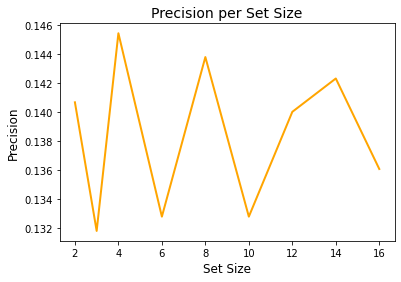

In [267]:
plt.plot(sizes, precision_list, color='orange', linewidth=2)

plt.title('Precision per Set Size', size=14)
plt.xlabel('Set Size', size=12)
plt.ylabel('Precision', size=12)


plt.show()

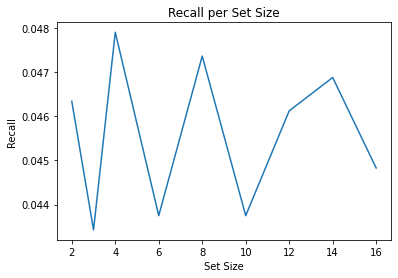

In [268]:
plt.plot(sizes, recall_list)

plt.title('Recall per Set Size')
plt.xlabel('Set Size')
plt.ylabel('Recall')


plt.show()

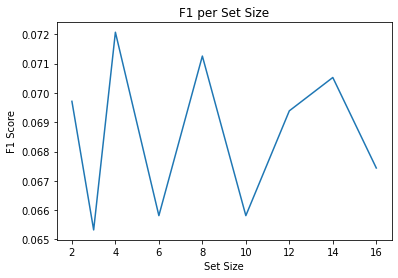

In [269]:
plt.plot(sizes, F1_list)

plt.title('F1 per Set Size')
plt.xlabel('Set Size')
plt.ylabel('F1 Score')


plt.show()

In [275]:
U, V, b = GBPRplus(train_matrix, rho=1, iterations=75, latent_features=2, reg_terms= (0.0001, 0.0001, 0.0001))
pred = np.dot(U, V.T) + b

train_replace = pred.min() - 1

for u, i in training:
    pred[u][i] = train_replace
    
user_rec = get_recommendations(pred, k=10)

get_metrics(test_matrix, user_rec)

Precision : 0.14081967213114754
Recall : 0.04639481501485282
F1 Score : 0.06979484054438351


(0.14081967213114754, 0.04639481501485282, 0.06979484054438351)

In [276]:
U, V, b = GBPRplus(train_matrix, rho=1, iterations=75, latent_features=2)
pred = np.dot(U, V.T) + b

train_replace = pred.min() - 1

for u, i in training:
    pred[u][i] = train_replace
    
user_rec = get_recommendations(pred, k=10)

get_metrics(test_matrix, user_rec)

Precision : 0.14737704918032787
Recall : 0.04855522549284364
F1 Score : 0.07304489132642698


(0.14737704918032787, 0.04855522549284364, 0.07304489132642698)